In [67]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('ggplot')

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import roc_curve, RocCurveDisplay, precision_recall_curve, PrecisionRecallDisplay, roc_auc_score

# Full case analysis

- For the modeling approach I have decided to build a RF model to find important features that can be later used in logistic regression for interpretability. At the same time, we can compare the effectiveness of linear vs complex algorithms on this problem. 
- for model evaluation train/test data split with stratification to account for the data imbalance and increased weight on default observation was set to prioritize classification of them.

In [68]:
def split_data(df):
    X, default = df[x_labels], df['default']
    X_train, X_test, y_train, y_test = train_test_split(X, default, stratify=default,test_size=0.33, random_state=42)
    return X, default,  X_train, X_test, y_train, y_test

df = pd.read_csv('data/full_case.csv', index_col=0)
# columns of only variable names
x_labels = [i for i in df.columns if i not in ['ID', 'obs_date','default']]
# ill use this function alot to move around the two available datasets
X, default, X_train, X_test, y_train, y_test = split_data(df)

## Random forest

Generally speaking, leaving it up to default options of random forest usually works, I just want to get a baseline for further tuning and testing the imputed set. 

Things I tested were: 
- different number of trees, 
- add some pruning 
- adding different weights on default observations to prioritize these predictions. 

I'm not sure how big of a problem is falsely classifying a default, I'm thinking of it in a sick patient scenario where it results in additional verification procedures are required to find if the diagnosis is correct. But it's definitely important to catch as many defaults as possible while not having to verify all of the false positives later on.

              precision    recall  f1-score   support

  No default       0.98      0.88      0.93     33790
     Default       0.28      0.76      0.41      2084

    accuracy                           0.87     35874
   macro avg       0.63      0.82      0.67     35874
weighted avg       0.94      0.87      0.90     35874



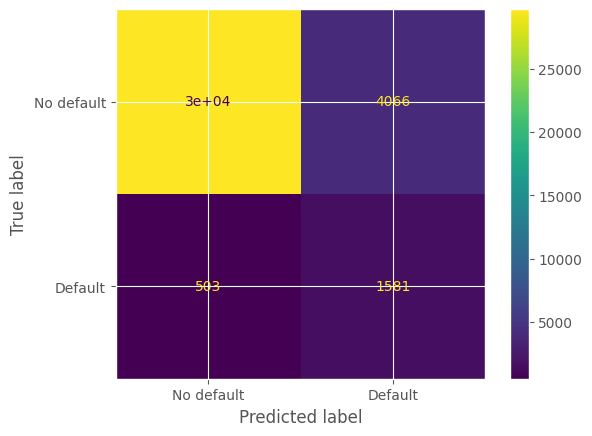

In [69]:
def train_rf(X_train, y_train, y_test):
    clf = RandomForestClassifier(
        n_estimators = 1000,
        class_weight={0: 1, 1: 10},
        ccp_alpha = 0.001, 
        random_state=0, n_jobs=4)
    clf.fit(X_train, y_train)

    y_p = clf.predict(X_test)
    print(classification_report(y_test, y_p, target_names=['No default', 'Default']))

    cm = confusion_matrix(y_test, y_p, labels=clf.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['No default', 'Default'])
    disp.plot()
    plt.show()
    return clf

clf_rf = train_rf(X_train, y_train, y_test)

So we catch around $75\%$ observations out of all defaults. The prediction is not so pure only 1600 out of 5600 observations were true defaults as a consequence of prioritizing defaults.

### RF feature importance

We use feature importance as a feature selection algorithm for logistics regression. There is a lot of unexplained uncertainty when we look at the standard deviations but taking the top 10 variables impacting the purity of a leaf is a good starting point.

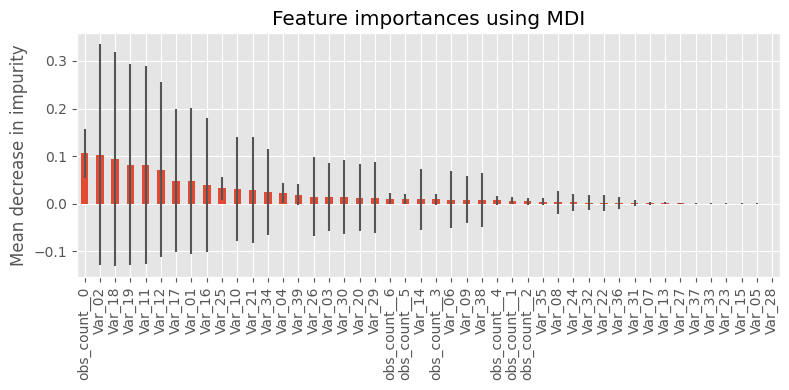

In [70]:
def plot_importance(clf):
    importances = clf.feature_importances_
    forest_importances = pd.Series(importances, index=x_labels)
    sorted_idx = np.argsort(-forest_importances)
    std = np.std([tree.feature_importances_ for tree in clf.estimators_], axis=0)

    fig, ax = plt.subplots(1, 1, figsize=(8, 4))
    forest_importances[sorted_idx].plot.bar(yerr=std[sorted_idx], ax=ax)
    ax.set_title("Feature importances using MDI")
    ax.set_ylabel("Mean decrease in impurity")
    fig.tight_layout()
    return sorted_idx

sorted_idx = plot_importance(clf_rf)

## Logistic regression

The default settings for logistic regression already incorporate L2 regularization to avoid overfitting so let's just see the results.

              precision    recall  f1-score   support

  No default       0.97      0.84      0.90     33790
     Default       0.20      0.65      0.31      2084

    accuracy                           0.83     35874
   macro avg       0.59      0.74      0.61     35874
weighted avg       0.93      0.83      0.87     35874



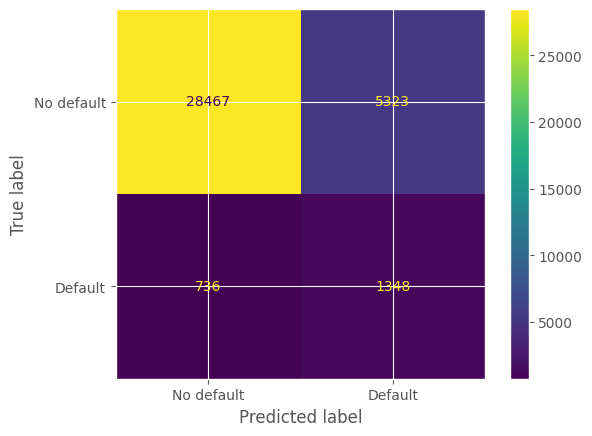

In [81]:
def train_lr(X_train, x_subset, y_train, y_test):
    clf = LogisticRegression(
        n_jobs=-1,
        class_weight={0: 1, 1: 10},
        random_state=0,
    ).fit(X_train.iloc[:, x_subset], y_train)

    y_p = clf.predict(X_test.iloc[:, x_subset])

    print(classification_report(y_test, y_p, target_names=['No default', 'Default']))

    cm = confusion_matrix(y_test, y_p, labels=clf.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['No default', 'Default'])
    disp.plot()
    plt.show()
    return clf, y_p


x_subset_1 = sorted_idx[:10].to_list()
clf_lr, pred_lr = train_lr(X_train,x_subset_1, y_train, y_test)

The performance of logistic regression is good especially when we compare it to the Random Forest. We can correctly classify $65\%$ of all defaults using a linear algorithm when the complex structure of Random Forest can classify $75\%$ of them.

# Imputed case

In this section, I will repeat the model training procedure to find out if there was some additional information in the missing data.

In [82]:
df = pd.read_csv('data/df_imputed.csv', index_col=0)
X, default, X_train, X_test, y_train, y_test = split_data(df)

## Random forest

              precision    recall  f1-score   support

  No default       0.99      0.87      0.92     45556
     Default       0.27      0.79      0.40      2857

    accuracy                           0.86     48413
   macro avg       0.63      0.83      0.66     48413
weighted avg       0.94      0.86      0.89     48413



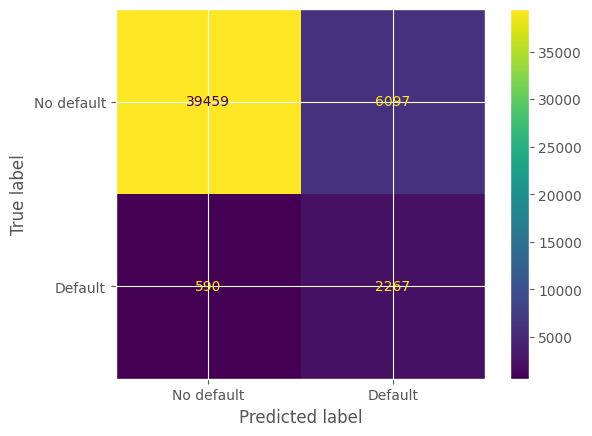

In [84]:
clf_rf_imp = train_rf(X_train, y_train, y_test)

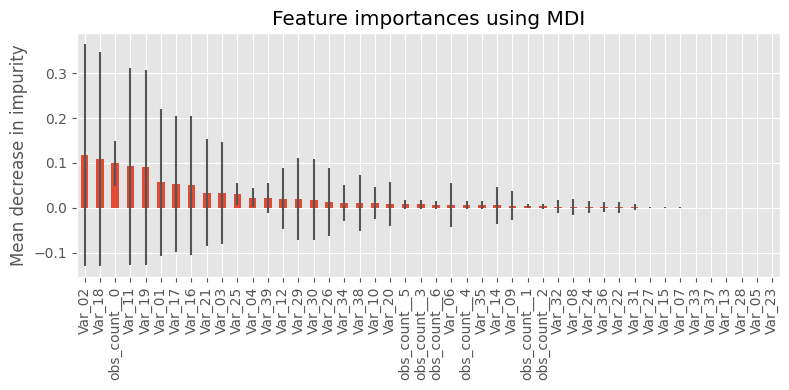

In [87]:
sorted_idx2 = plot_importance(clf_rf_imp)

## Logistic regression

              precision    recall  f1-score   support

  No default       0.98      0.81      0.89     45556
     Default       0.20      0.75      0.31      2857

    accuracy                           0.81     48413
   macro avg       0.59      0.78      0.60     48413
weighted avg       0.93      0.81      0.85     48413



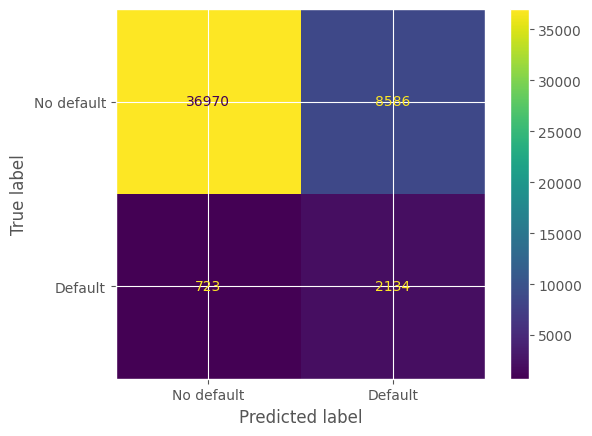

In [89]:
x_subset_2 = sorted_idx2[:10].to_list()
clf_lr_imp, pred_lr = train_lr(X_train, x_subset_2, y_train, y_test)

# AUC and PR curves for logistic regression

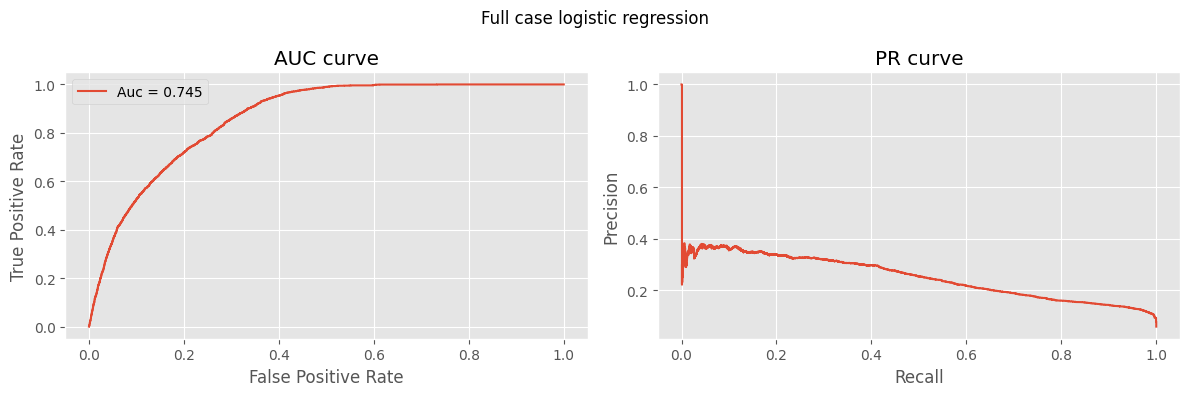

In [97]:

def roc_pr_curve(clf, df, subset):
    ax1.set_title("AUC curve")
    ax2.set_title("PR curve")
    X, default, X_train, X_test, y_train, y_test = split_data(df)

    y_score = clf.decision_function(X_test.iloc[:, subset])
    y_pred = clf.predict(X_test.iloc[:, subset])
    auc = round(roc_auc_score(y_test, y_pred), 3)

    fpr, tpr, _ = roc_curve(y_test, y_score, pos_label=clf.classes_[1])
    roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr)

    prec, recall, _ = precision_recall_curve(y_test, y_score, pos_label=clf.classes_[1])
    pr_display = PrecisionRecallDisplay(precision=prec, recall=recall)

    roc_display.plot(ax=ax1)
    pr_display.plot(ax=ax2)
    ax1.legend([f'Auc = {auc}'])

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
df = pd.read_csv('data/full_case.csv', index_col=0)
roc_pr_curve(clf_lr, df, x_subset_1)
fig.suptitle("Full case logistic regression")
plt.tight_layout()

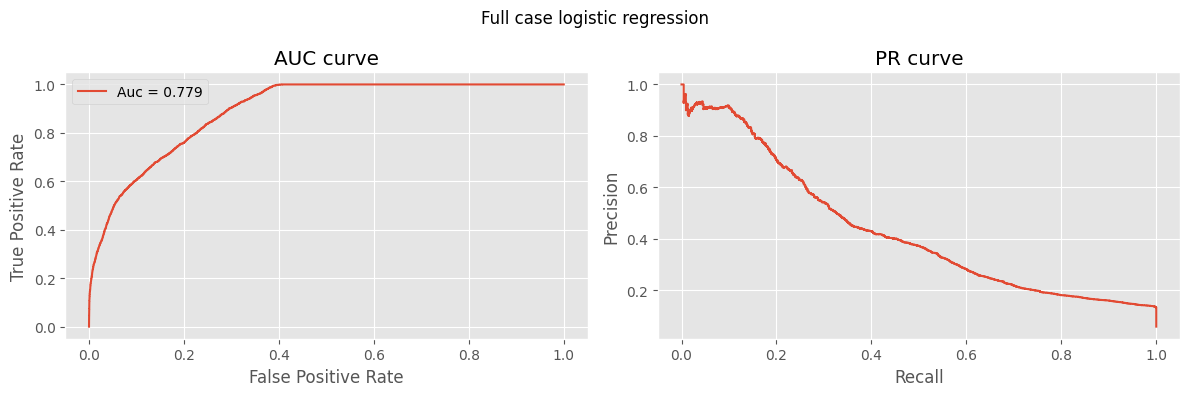

In [99]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
df = pd.read_csv('data/df_imputed.csv', index_col=0)
roc_pr_curve(clf_lr_imp, df, x_subset_2)
fig.suptitle("Full case logistic regression")
plt.tight_layout()

- The imputed case model performs better achieving a higher AUC score, also we can achieve $100\%$ classification of true defaults while having $40\%$ of false alarms when the full case model achieves it at $60\%$ of false alarms.
- depending on the costs associated with further analysis of miss classified cases it is possible to optimize the threshold at which we classify them as defaults.
- the PR curve for the full case model tells that it is a bad classifier as the default predictions contain a lot of false positives cases across all thresholds and the imputed case provides a better trade-off.

## Conclusion

- There is a $10\%$ improvement in the ability to predict the default of a company by adding inputted data cases, so I think that it was a correct decision to impute them with 0 as these were not missing at random cases
- It looks like it is still a highly linear problem as the random forest performs only slightly better on the imputed data. There is just a lot of unexplained variance and we would need different data to account for it.
- The imputed case logistic regression is definitely a better-performing model providing a better prediction trade-off between falsely classified default and non-default observations.

In [14]:
X_best = X[[x_labels[i] for i in sorted_idx2[:10]]].copy()
[x_labels[i] for i in sorted_idx2[:10]]

['Var_02',
 'Var_18',
 'obs_count__0',
 'Var_11',
 'Var_19',
 'Var_01',
 'Var_17',
 'Var_16',
 'Var_21',
 'Var_03']

In [26]:
clf_lr_imp.coef_

array([[ 3.25153255,  3.25153255,  1.74036438, -2.12172002, -2.12172002,
         0.28356888, -0.12298125,  0.28356888, -1.10417366,  0.24431698]])

# Investigating the names of variables for interpretability and finding out that they privde the same infromation in alot of cases

In [64]:
X_best.corr()

,Var_02,Var_18,obs_count__0,Var_11,Var_19,Var_01,Var_17,Var_16,Var_21,Var_03,default
Var_02,1.000000,1.000000,-0.130064,0.964131,0.964131,0.957656,0.962524,0.957656,0.927916,0.635148,0.284055
Var_18,1.000000,1.000000,-0.130064,0.964131,0.964131,0.957656,0.962524,0.957656,0.927916,0.635148,0.284055
obs_count__0,-0.130064,-0.130064,1.000000,-0.105658,-0.105658,-0.115094,-0.112634,-0.115094,-0.103748,-0.051257,0.148439
Var_11,0.964131,0.964131,-0.105658,1.000000,1.000000,0.969738,0.959064,0.969738,0.970939,0.756874,0.248038
Var_19,0.964131,0.964131,-0.105658,1.000000,1.000000,0.969738,0.959064,0.969738,0.970939,0.756874,0.248038
Var_01,0.957656,0.957656,-0.115094,0.969738,0.969738,1.000000,0.903459,1.000000,0.974339,0.725843,0.254931
Var_17,0.962524,0.962524,-0.112634,0.959064,0.959064,0.903459,1.000000,0.903459,0.897953,0.660185,0.263715
Var_16,0.957656,0.957656,-0.115094,0.969738,0.969738,1.000000,0.903459,1.000000,0.974339,0.725843,0.254931
Var_21,0.927916,0.927916,-0.103748,0.970939,0.970939,0.974339,0.897953,0.974339,1.000000,0.768119,0.208201
Var_03,0.635148,0.635148,-0.051257,0.756874,0.756874,0.725843,0.660185,0.725843,0.768119,1.000000,0.125654


              precision    recall  f1-score   support

  No default       0.98      0.81      0.89     45556
     Default       0.20      0.74      0.31      2857

    accuracy                           0.81     48413
   macro avg       0.59      0.78      0.60     48413
weighted avg       0.93      0.81      0.85     48413



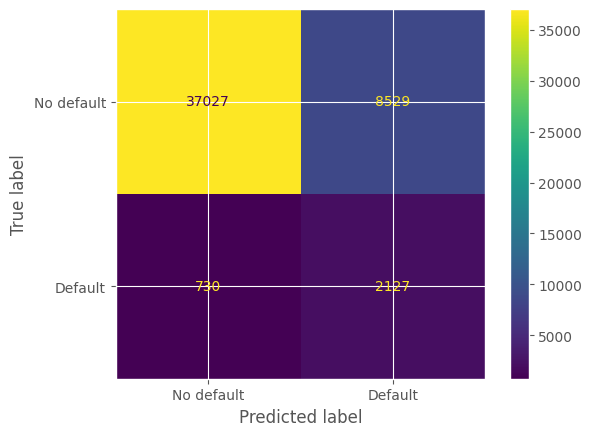

In [114]:
df = pd.read_csv('data/df_imputed.csv', index_col=0)
X, default, X_train, X_test, y_train, y_test = split_data(df)

# first 10 from feature importance and then selecting out the correlated ones
x_subset_3 = sorted_idx2[:10][[0, 2, 3, 5, 8, 9]].tolist()
clf_lr_imp, pred_lr = train_lr(X_train, x_subset_3, y_train, y_test)

In [115]:
clf_lr_dc.coef_

array([[ 6.39068293,  1.74123319, -4.34302644,  0.64919703, -1.09486351,
         0.24186154]])

In [119]:
# saving for pca
X_decorr = pd.concat([X.iloc[:, x_subset_3], default], axis=1)
X_decorr.to_csv('data/df_best.csv')

In [118]:
X_decorr

,Var_02,obs_count__0,Var_11,Var_01,Var_21,Var_03,default
0,-0.724064,1,-0.553277,-0.613603,-0.526584,-0.222252,0
1,-0.707214,0,-0.551279,-0.611993,-0.526349,-0.222246,0
2,-0.712806,0,-0.551952,-0.614145,-0.526618,-0.222275,0
3,-0.694199,0,-0.549676,-0.612755,-0.526691,-0.222221,0
4,-0.714466,0,-0.552150,-0.613094,-0.526146,-0.222223,0
...,...,...,...,...,...,...,...
146699,-0.711024,1,-0.551739,-0.605806,-0.524460,-0.222230,0
146700,-0.143944,1,-0.407013,-0.174470,-0.411583,-0.221650,0
146701,-0.375404,0,-0.488896,-0.383161,-0.236472,-0.222352,0
146702,-0.453892,0,-0.508429,-0.440869,-0.224855,-0.222262,0
